# Introduction 

The aim of this section is to train a neural network that can accurately classify the agency that responded to a 311 call. In the exploratory analysis section, we saw that none of the community districts' numeric indicators were highly correlated with any of the dummy-encoded agency categories. Intuitively, one may expect the call's descriptor to be the best predictor of the responding agency, but given that the descriptors consist of natural language data, they will need to undergo additional preprocessig before being fed into a model.

# Loading Dependencies

In [1]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import random
import re

from sklearn import preprocessing
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.preprocessing.text import Tokenizer
from keras import models
from keras import layers
from keras import optimizers
from keras.utils.np_utils import to_categorical

In [2]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
path = '/content/drive/MyDrive/Colab Notebooks/df_final.csv'
df = pd.read_csv(path, index_col=0)

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


# Assessing Model Performance

With perfectly balanced classes, a model's accuracy is acceptable if it exceeds the expected accuracy rate of simply picking a random class. With heavily imbalanced classes, however, a model's accuracy can instead be compared to that of picking the majority class. Below is the expected accuracy rate if we were to predict that all calls in a sample were responded to by the NYPD.

In [4]:
len(df[df.agency =='NYPD'])/sum(df.agency.value_counts()) * 100

52.613013902155835

While the aim will be to maximize model accuracy, any classifier that is at least 53% accurate will out-perform the simple assignment of all calls to the NYPD.

# Sampling the Data 
The dataset currently consists of more than one million rows:

In [5]:
len(df)

1379786

Retrieving the training data from a representative sample, rather than the entire dataset, will save time in the training process and ideally not result in a significant decline in accuracy.

In training classification models, we'll want to ensure that complaint descriptors from every agency category are represented. This way, the model will also be able to recognize encoded descriptors that correspond to agencies that rarely receive calls. However, training a model on samples of equal length from each agency may lead to confusion when it is presented with new, imbalanced data. We'll oversample the minority classes, but ensure that the largest samples are those agencies that receive the most calls. This will allow the diversity of descriptors associated with each agency to be captured in the samples. Below, we create and print a dictionary with the class weights.

In [6]:
weights_dict = {}

for agency, count in list(zip(df.agency.value_counts().index, df.agency.value_counts().values)):
  weight = count/len(df)
  weights_dict[agency] = weight
weights_dict

{'DCA': 0.007849768007502613,
 'DEP': 0.057544430803037575,
 'DOB': 0.031322248522596983,
 'DOE': 0.0003138167802833193,
 'DOHMH': 0.022252001397318134,
 'DOITT': 0.00011233626084044916,
 'DOT': 0.059362103978443034,
 'DPR': 0.08357020581452486,
 'DSNY': 0.04376330822315924,
 'EDC': 0.004157891151236496,
 'HPD': 0.12691315899711986,
 'NYPD': 0.5261301390215584,
 'OSE': 0.03320152545394721,
 'TLC': 0.0035070655884318295}

In [7]:
df.agency.value_counts()

NYPD     725947
HPD      175113
DPR      115309
DOT       81907
DEP       79399
DSNY      60384
OSE       45811
DOB       43218
DOHMH     30703
DCA       10831
EDC        5737
TLC        4839
DOE         433
DOITT       155
Name: agency, dtype: int64

Next, we'll create a new dictionary with guidelines for the number of samples to be drawn from each class. The class weights are multiplied by a term that results in the largest sample, NYPD, consisting of around 60k calls.

In [8]:
n_samples_dict = {}

for agency, weight in zip(weights_dict.keys(), weights_dict.values()):
  n_samples = int(15**4.3 * weight)
  n_samples_dict[agency] = n_samples

In [9]:
n_samples_dict

{'DCA': 895,
 'DEP': 6564,
 'DOB': 3573,
 'DOE': 35,
 'DOHMH': 2538,
 'DOITT': 12,
 'DOT': 6771,
 'DPR': 9533,
 'DSNY': 4992,
 'EDC': 474,
 'HPD': 14477,
 'NYPD': 60018,
 'OSE': 3787,
 'TLC': 400}

The below function returns weighted samples of an agency that's passed in. Agencies that appear in fewer than 400 rows are sampled with replacement, such
that the minimum sample size is 400.

In [10]:
def get_weighted_sample(agency):
  
  """Takes in an agency name as a string, and creates a subset with all rows
     with a match in the agency column. If the number of rows is greater than 
     that of one of the minority classes, DOE, a weighted sample is returned. 
     For the two smallest minority classes, sample sizes of at least 400 are 
     returned."""

  agency_subset = df[df.agency == agency]

  n_samples = n_samples_dict[agency]
  
  weighted_sample = agency_subset.sample(n=n_samples, random_state=9)

  return weighted_sample

The function is applied below to each unique agency to create a dataframe of samples. These are conatenated in 'weighted_df' and the index is reset.

In [11]:
DCA = get_weighted_sample('DCA')
DEP = get_weighted_sample('DEP')
DOB = get_weighted_sample('DOB')
DOE = get_weighted_sample('DOE')
DOHMH = get_weighted_sample('DOHMH')
DOITT = get_weighted_sample('DOITT')
DOT = get_weighted_sample('DOT')
DPR = get_weighted_sample('DPR')
DSNY = get_weighted_sample('DSNY')
EDC = get_weighted_sample('EDC')
HPD = get_weighted_sample('HPD')
NYPD = get_weighted_sample('NYPD')
OSE = get_weighted_sample('OSE')
TLC = get_weighted_sample('TLC')

In [12]:
weighted_df = pd.concat([DCA, DEP, DOB, DOE, DOHMH, DOITT,
                        DOT, DPR, DSNY, EDC, HPD, NYPD, OSE, TLC])
weighted_df.reset_index(inplace=True)

In order for the model to be tested on new data, it should have exposure to every unique descriptor in the dataset. The below code creates a list of every item in the original dataframe's unique descriptors that is not found in the sample dataframe.

In [13]:
descriptors_not_in_sample = []

for i in df.descriptor.unique():
  if i not in weighted_df.descriptor.unique():
    descriptors_not_in_sample.append(i)

len(descriptors_not_in_sample)

168

The list above captures many of the less common descriptors that were not captured in the sample data. Below, we create a dataframe with all calls that match these descriptors and concatenate them with the weighted sample dataframe.

In [14]:
descriptors_not_in_sample_df = df[df.descriptor.isin(descriptors_not_in_sample)]

In [15]:
weighted_df = pd.concat([DCA, DEP, DOB, DOE, DOHMH, DOT, DOITT,
                         DPR, DSNY, EDC, HPD, NYPD, OSE, TLC,
                         descriptors_not_in_sample_df])
weighted_df.reset_index(inplace=True)

In [16]:
#confirm that the number of unique descriptors is the same for both dataframes
len(weighted_df.descriptor.unique()) == len(df.descriptor.unique())

True

The classes remain imbalanced, but no agency is represented by only a handful of samples, as would have been the case with simple random sampling:

In [17]:
weighted_df.agency.value_counts()

NYPD     60042
HPD      14521
DPR       9556
DOT       6999
DEP       6684
DSNY      5022
OSE       3787
DOB       3618
DOHMH     2675
DCA        978
EDC        474
TLC        412
DOE         53
DOITT       37
Name: agency, dtype: int64

# Keras Neural Network

## Preparing the Training and Test Data

Using the dataframe of weighted samples, we assign 'X' to the descriptor column and 'y' to the agency column. 

In [18]:
X = weighted_df.descriptor
y = weighted_df.agency

The [Keras Tokenizer](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) `fit_on_texts()` method, used below, "updates internal vocabulary based on a list of texts." In this case, the list of texts is all descriptors in the weighted sample. The `texts_to_matrix()` method converts the list of texts to a NumPy matrix. Specifying the mode "binary" means that only the presence or absence of each item in the tokenizer's vocabulary will be accounted for in the matrix.

In [19]:
descriptors = X
tokenizer = Tokenizer() 

tokenizer.fit_on_texts(descriptors) 
descriptor_onehot = tokenizer.texts_to_matrix(descriptors, mode='binary')
word_index = tokenizer.word_index

The word index is a dictionary that contains words in the tokenizer's vocabulary as keys, and integers that correspond to the keys' frequency rank as values. The first ten items of the dictionary are printed below, and we can see that the most frequent words have the lowest values. The highest value in the dictionary is 1114.

In [20]:
# reversed_word_index = dict(map(reversed, word_index.items()))
# list(reversed_word_index.items())[0:10]
print(list(word_index.items())[0:10])
print('Max:', max(word_index.values()))

[('music', 1), ('loud', 2), ('party', 3), ('access', 4), ('no', 5), ('blocked', 6), ('hydrant', 7), ('truck', 8), ('car', 9), ('in', 10)]
Max: 1114


The content and shape of the one-hot encoded descriptors are displayed below.

In [21]:
display(descriptor_onehot)

print('Shape:', descriptor_onehot.shape)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Shape: (114858, 1115)


The number of rows is the same as the number of rows in X, and correspond to an individual call:

In [22]:
X.shape

(114858,)

Each column corresponds to one of 1,110 words in the tokenizer's vocabulary. If the word for a column is present in a given call's descriptor, its value at the call's corresponding row will be '1.' Otherwise, it will be '0.'

The label encoder used below assigns a unique integer to each of the categories in the agency column. The [keras.utils.to_categorical
](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical) method "converts a class vector (integers) to binary class matrix."

In [23]:
agency = y

le = preprocessing.LabelEncoder() 
le.fit(agency)
agency_cat = le.transform(agency)  
agency_onehot = to_categorical(agency_cat)

Let's examine the content and shape of the encoded agency data:

In [24]:
display(agency_onehot)
print('Shape:', agency_onehot.shape)

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

Shape: (114858, 14)


Each row corresponds to a call, and each column corresponds to an agency. The value in a given cell indicates whether the agency in its column either responded ('1'), or did not respond ('0'), to the call in its row.

Now that both X and y have been encoded, we'll create a random split of training and test data.

In [25]:
test, train, label_test, label_train = train_test_split(descriptor_onehot, agency_onehot, test_size=.1, random_state=6)

## Baseline Model

We'll start with a baseline model before writing a function to assess how different parameters affect the model's performance. For all of the models, we'll use the "categorical crossentropy" loss function, which is appropriate for multiclass classification. Accuracy will also be the performance metric used for each model, but our interpretation of the accuracy should be informed by the large number of classes and significant class imbalance.

In [26]:
model1 = models.Sequential()

model1.add(layers.Dense(50, activation='relu', input_shape=(test.shape[1],)))
model1.add(layers.Dense(25, activation='relu'))
model1.add(layers.Dense(14, activation='softmax'))


opt = tf.keras.optimizers.SGD(learning_rate=0.001)
model1.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['acc'])

To avoid overfitting the model to the training data, we'll add the `validation_split` parameter, and an early stopping callback that monitors validation loss, to our fit function.

In [27]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model1.fit(train,
                    label_train,
                    validation_split=0.20,
                    epochs=62,
                    batch_size=32,
                    callbacks=[es])

Epoch 1/62
288/288 [==============================] - 1s 3ms/step - loss: 2.5556 - acc: 0.4673 - val_loss: 2.4822 - val_acc: 0.5231
Epoch 2/62
288/288 [==============================] - 1s 2ms/step - loss: 2.4022 - acc: 0.5258 - val_loss: 2.3243 - val_acc: 0.5231
Epoch 3/62
288/288 [==============================] - 1s 2ms/step - loss: 2.2386 - acc: 0.5258 - val_loss: 2.1567 - val_acc: 0.5231
Epoch 4/62
288/288 [==============================] - 1s 2ms/step - loss: 2.0641 - acc: 0.5258 - val_loss: 1.9811 - val_acc: 0.5231
Epoch 5/62
288/288 [==============================] - 1s 2ms/step - loss: 1.8944 - acc: 0.5258 - val_loss: 1.8262 - val_acc: 0.5231
Epoch 6/62
288/288 [==============================] - 1s 2ms/step - loss: 1.7618 - acc: 0.5258 - val_loss: 1.7203 - val_acc: 0.5231
Epoch 7/62
288/288 [==============================] - 1s 2ms/step - loss: 1.6777 - acc: 0.5258 - val_loss: 1.6561 - val_acc: 0.5231
Epoch 8/62
288/288 [==============================] - 1s 2ms/step - loss: 1.

Let's look at the model's loss and accuracy score.

In [28]:
results = model1.evaluate(test, label_test, batch_size=32)

3231/3231 [==============================] - 5s 2ms/step - loss: 0.9985 - acc: 0.6901


The function below plots the model's loss and accuracy curves, which will provide a better visual sense of how the values for these metrics changed as the number of epochs increased.

In [56]:
def plot_loss_acc(history):
 
  """Takes in a Keras history object and returns a 15*6 figure displaying the 
     model's loss and accuracy curves."""


  fig, (ax1, ax2) = plt.subplots(nrows=1,
                               ncols=2,
                               figsize=(15, 6))

  ax_font = {'fontsize': 12, 'family': 'serif', 
             'color': '#58508d', 'weight': 'bold'}
  title_font = {'fontsize': 14, 'family': 'serif',
                'color': '#58508d', 'weight': 'bold'}


  ax1.plot(history.history['acc'], color='#D8A7B1', linewidth=3)
  ax1.grid(color='g', linestyle='-', linewidth=.09)
  ax1.plot(history.history['val_acc'], color='#05234C', linewidth=3)
  ax1.set_title('Model Accuracy', fontdict=title_font)
  ax1.set_ylabel('Accuracy', fontdict=ax_font)
  ax1.set_xlabel('Number of epochs', fontdict=ax_font)
  ax1.legend(['train', 'validation'], loc='upper left')


  ax2.plot(history.history['loss'], color='#D8A7B1', linewidth=3)
  ax2.grid(color='g', linestyle='-', linewidth=.09)
  ax2.plot(history.history['val_loss'], color='#05234C', linewidth=3)
  ax2.set_title('Model Loss', fontdict=title_font)
  ax2.set_ylabel('Loss', fontdict=ax_font)
  ax2.set_xlabel('Number of epochs', fontdict=ax_font)
  ax2.legend(['train', 'validation'], loc='upper right')

  fig.show()

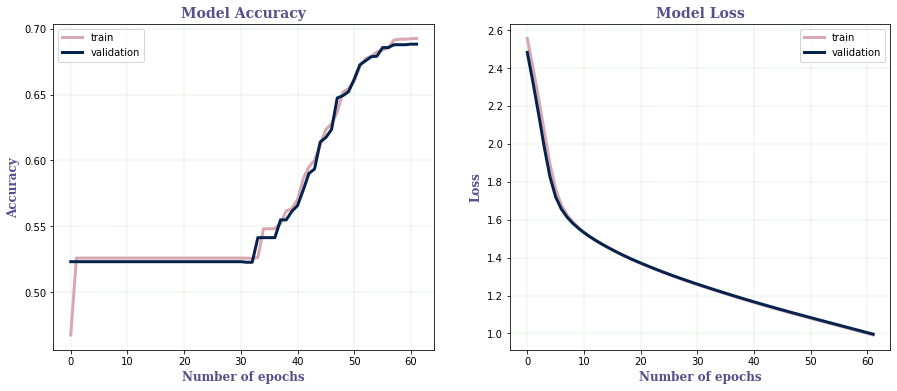

In [57]:
plot_loss_acc(history)

The accuracy score improves steadily after 30 epochs, while the loss steadily drops. We'll also create a random subset of the data that has not been resampled to evaluate the model's performance, and apply the same preprocessing steps as above.

In [31]:
random_df = df.sample(len(weighted_df), random_state=6)

In [32]:
descriptors_not_in_sample = []

for i in df.descriptor.unique():
  if i not in random_df.descriptor.unique():
    descriptors_not_in_sample.append(i)

descriptors_not_in_sample

['bingo hall',
 'waterwaycolor ihd',
 'oil, grease in water qd',
 'safety inspectionretaining walls may ',
 'allergy information',
 'other industrial waste problem use comments for dep internal use only iz',
 'indoor pool over capacity',
 'jewelry appraiser',
 'graffiti litter on phone',
 'phone blocking sidewalk',
 'sediment',
 'snake',
 'high grass',
 'cloudy or milky, other use comments qbz',
 'push button',
 'cloudy or milky water qb',
 'absent',
 'inspection work order dob',
 'cigarette vending machine',
 'mast arm',
 'unauthorized posting of signs',
 'ped flasher',
 'enclosure cap',
 'maintenance cover',
 'booting company',
 'warning signal lamp',
 'immigration services',
 'oil spill into basin sewer  small iabs',
 'roof gutters',
 'platform condition',
 'manhole cover broken making noise sb',
 'dogs or cats not sold',
 'bent loose',
 'toxic chemical material',
 'basement',
 'gasoline spill iaa',
 'puddle on sidewalk',
 'warning signal',
 'remove debris',
 'plants odor related pr

In [33]:
descriptors_not_in_sample_df = df[df.descriptor.isin(descriptors_not_in_sample)]
random_df = pd.concat([random_df, descriptors_not_in_sample_df])
random_df.reset_index(inplace=True)

In [34]:
random_X = random_df.descriptor
random_y = random_df.agency

In [35]:
r_descriptors = random_X
tokenizer = Tokenizer() 

tokenizer.fit_on_texts(r_descriptors) 
r_descriptor_onehot = tokenizer.texts_to_matrix(r_descriptors, mode='binary')
word_index = tokenizer.word_index

In [36]:
r_agency = random_y

le = preprocessing.LabelEncoder() 
le.fit(r_agency)
r_agency_cat = le.transform(r_agency)  
r_agency_onehot = to_categorical(r_agency_cat)

In [37]:
random.seed(999)
test_index = random.sample(range(1,10000), 1500)

r_test = r_descriptor_onehot[test_index]
r_label_test = r_agency_onehot[test_index]

In [38]:
random_results = model1.evaluate(r_descriptor_onehot, r_agency_onehot, batch_size=32)

3622/3622 [==============================] - 6s 2ms/step - loss: 1.1589 - acc: 0.6288


The model had 62% accuracy on the random sample. This score can be improved by testing different parameters in the model.

## Parameter Tuning

In [58]:
def create_model(X_train, y_train, X_test, y_test, params):

    model = models.Sequential()
    model.add(layers.Dense(50, activation=params['activation 1'], 
                           input_shape=(test.shape[1],)))
    model.add(layers.Dense(25, activation=params['activation 2']))
    model.add(layers.Dense(14, activation=params['activation 3']))

    opt = params['opt']
    model.compile(optimizer=opt,
              loss=params['loss'],
              metrics=['acc'])
    
    es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    history = model.fit(X_train,
                    y_train,
                    epochs=params['epochs'],
                    batch_size=params['batch_size'],
                    validation_split=0.20)
    
    print(model.summary)

    print('Test Accuracy:')
    model.evaluate(X_test, y_test, batch_size=params['batch_size'])
    
    print('Random Sample Accuracy:')
    model.evaluate(r_test, r_label_test, batch_size=params['batch_size'])
    
    plot_loss_acc(history)
    
    return history, model

In [59]:
model2_params = {'activation 1': 'relu', 
                 'activation 2': 'softmax', 
                 'activation 3': 'softmax', 
                 'opt': keras.optimizers.Adam(lr=0.0001),
                 'loss': 'categorical_crossentropy',
                 'epochs': 75, 
                 'batch_size': 16, 
                 }

Epoch 1/75
575/575 [==============================] - 1s 2ms/step - loss: 2.5665 - acc: 0.3603 - val_loss: 2.4759 - val_acc: 0.5231
Epoch 2/75
575/575 [==============================] - 1s 2ms/step - loss: 2.3728 - acc: 0.5258 - val_loss: 2.2766 - val_acc: 0.5231
Epoch 3/75
575/575 [==============================] - 1s 2ms/step - loss: 2.1752 - acc: 0.5258 - val_loss: 2.0833 - val_acc: 0.5231
Epoch 4/75
575/575 [==============================] - 1s 2ms/step - loss: 2.0039 - acc: 0.5257 - val_loss: 1.9341 - val_acc: 0.5226
Epoch 5/75
575/575 [==============================] - 1s 2ms/step - loss: 1.8692 - acc: 0.5581 - val_loss: 1.8096 - val_acc: 0.5827
Epoch 6/75
575/575 [==============================] - 1s 2ms/step - loss: 1.7521 - acc: 0.5899 - val_loss: 1.6997 - val_acc: 0.6018
Epoch 7/75
575/575 [==============================] - 1s 2ms/step - loss: 1.6480 - acc: 0.6054 - val_loss: 1.6021 - val_acc: 0.6149
Epoch 8/75
575/575 [==============================] - 1s 2ms/step - loss: 1.

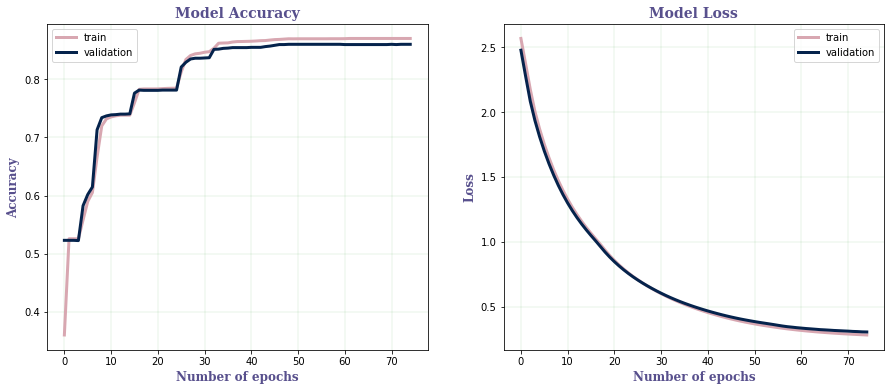

In [60]:
model2_history, model2 = create_model(train, label_train, test, label_test, model2_params)

In [61]:
model3_params = {'activation 1': 'relu', 
                 'activation 2': 'relu', 
                 'activation 3': 'softmax', 
                 'opt': tf.keras.optimizers.SGD(learning_rate=0.01),
                 'loss': 'categorical_crossentropy',
                 'epochs': 45, 
                 'batch_size': 16, 
                 }

Epoch 1/45
575/575 [==============================] - 1s 2ms/step - loss: 1.6907 - acc: 0.5245 - val_loss: 1.3770 - val_acc: 0.5231
Epoch 2/45
575/575 [==============================] - 1s 2ms/step - loss: 1.2472 - acc: 0.5551 - val_loss: 1.1366 - val_acc: 0.5970
Epoch 3/45
575/575 [==============================] - 1s 2ms/step - loss: 1.0321 - acc: 0.6660 - val_loss: 0.9425 - val_acc: 0.6897
Epoch 4/45
575/575 [==============================] - 1s 2ms/step - loss: 0.8606 - acc: 0.7331 - val_loss: 0.7848 - val_acc: 0.7789
Epoch 5/45
575/575 [==============================] - 1s 2ms/step - loss: 0.7109 - acc: 0.8227 - val_loss: 0.6437 - val_acc: 0.8581
Epoch 6/45
575/575 [==============================] - 1s 2ms/step - loss: 0.5786 - acc: 0.8724 - val_loss: 0.5224 - val_acc: 0.8838
Epoch 7/45
575/575 [==============================] - 1s 2ms/step - loss: 0.4678 - acc: 0.8954 - val_loss: 0.4261 - val_acc: 0.9021
Epoch 8/45
575/575 [==============================] - 1s 2ms/step - loss: 0.

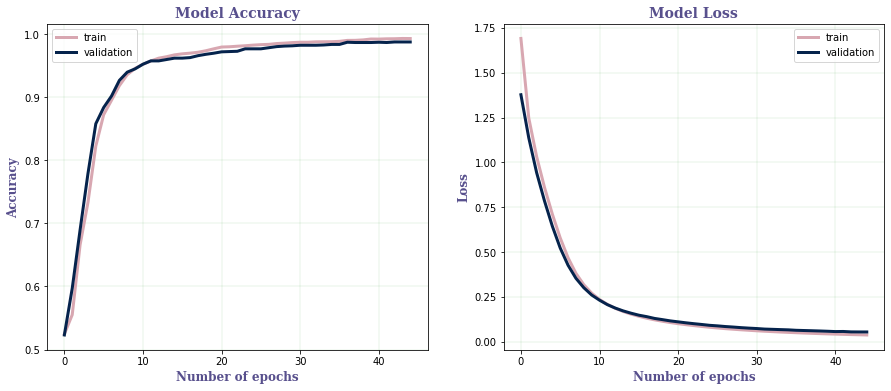

In [62]:
model3_history, model3 = create_model(train, label_train, test, label_test, model3_params)

In [63]:
model4_params = {'activation 1': 'relu', 
                 'activation 2': 'relu', 
                 'activation 3': 'softmax', 
                 'opt': tf.keras.optimizers.SGD(learning_rate=0.001),
                 'loss': 'categorical_crossentropy',
                 'epochs': 250, 
                 'batch_size': 50, 
                 }

Epoch 1/250
184/184 [==============================] - 1s 3ms/step - loss: 2.6350 - acc: 0.0759 - val_loss: 2.5977 - val_acc: 0.4987
Epoch 2/250
184/184 [==============================] - 0s 3ms/step - loss: 2.5643 - acc: 0.5128 - val_loss: 2.5330 - val_acc: 0.5265
Epoch 3/250
184/184 [==============================] - 0s 3ms/step - loss: 2.4981 - acc: 0.5257 - val_loss: 2.4668 - val_acc: 0.5231
Epoch 4/250
184/184 [==============================] - 0s 3ms/step - loss: 2.4330 - acc: 0.5258 - val_loss: 2.4036 - val_acc: 0.5231
Epoch 5/250
184/184 [==============================] - 0s 3ms/step - loss: 2.3695 - acc: 0.5258 - val_loss: 2.3406 - val_acc: 0.5231
Epoch 6/250
184/184 [==============================] - 1s 3ms/step - loss: 2.3061 - acc: 0.5258 - val_loss: 2.2772 - val_acc: 0.5231
Epoch 7/250
184/184 [==============================] - 0s 3ms/step - loss: 2.2413 - acc: 0.5258 - val_loss: 2.2121 - val_acc: 0.5231
Epoch 8/250
184/184 [==============================] - 0s 3ms/step - 

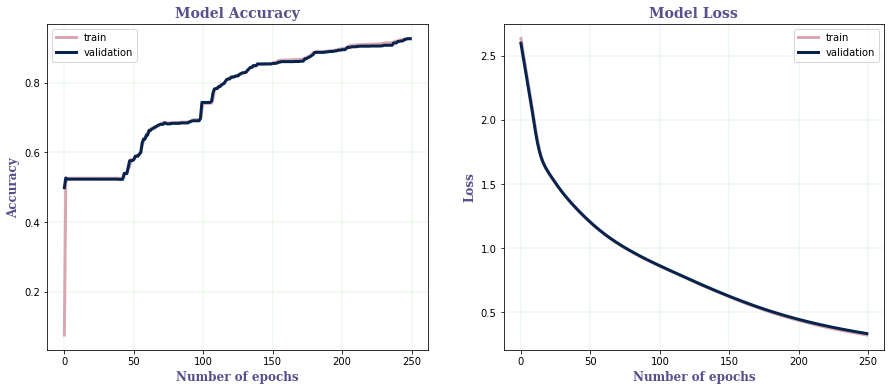

In [64]:
model4_history, model4 = create_model(train, label_train, test, label_test, model4_params)

In [65]:
model5_params = {'activation 1': 'relu', 
                 'activation 2': 'relu', 
                 'activation 3': 'softmax', 
                 'opt': tf.keras.optimizers.SGD(learning_rate=0.001),
                 'loss': 'categorical_crossentropy',
                 'epochs': 270, 
                 'batch_size': 40, 
                 }

Epoch 1/270
230/230 [==============================] - 1s 3ms/step - loss: 2.5951 - acc: 0.3791 - val_loss: 2.5421 - val_acc: 0.5361
Epoch 2/270
230/230 [==============================] - 0s 2ms/step - loss: 2.4930 - acc: 0.5280 - val_loss: 2.4467 - val_acc: 0.5231
Epoch 3/270
230/230 [==============================] - 0s 2ms/step - loss: 2.3953 - acc: 0.5258 - val_loss: 2.3465 - val_acc: 0.5231
Epoch 4/270
230/230 [==============================] - 0s 2ms/step - loss: 2.2912 - acc: 0.5258 - val_loss: 2.2406 - val_acc: 0.5231
Epoch 5/270
230/230 [==============================] - 0s 2ms/step - loss: 2.1812 - acc: 0.5258 - val_loss: 2.1292 - val_acc: 0.5231
Epoch 6/270
230/230 [==============================] - 1s 2ms/step - loss: 2.0671 - acc: 0.5258 - val_loss: 2.0151 - val_acc: 0.5231
Epoch 7/270
230/230 [==============================] - 0s 2ms/step - loss: 1.9516 - acc: 0.5258 - val_loss: 1.9034 - val_acc: 0.5231
Epoch 8/270
230/230 [==============================] - 1s 2ms/step - 

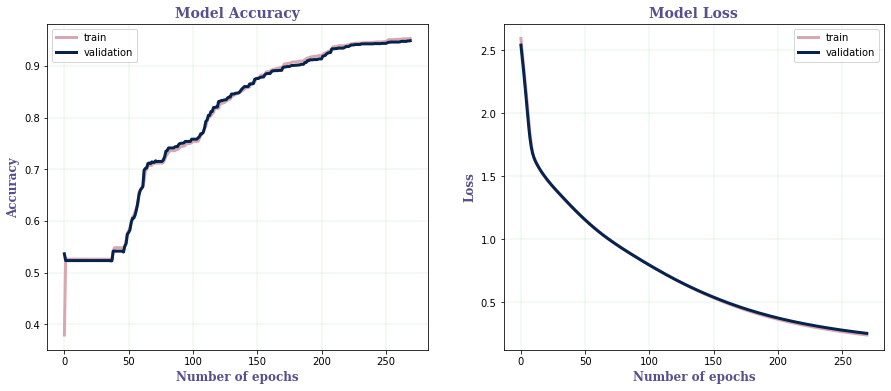

In [66]:
model5_history, model5 = create_model(train, label_train, test, label_test, model5_params)

In [67]:
model6_params = {'activation 1': 'relu', 
                 'activation 2': 'relu', 
                 'activation 3': 'softmax', 
                 'opt': tf.keras.optimizers.SGD(learning_rate=0.001),
                 'loss': 'categorical_crossentropy',
                 'epochs': 170, 
                 'batch_size': 30, 
                 }

Epoch 1/170
307/307 [==============================] - 1s 2ms/step - loss: 2.5981 - acc: 0.3037 - val_loss: 2.5528 - val_acc: 0.5244
Epoch 2/170
307/307 [==============================] - 1s 2ms/step - loss: 2.5070 - acc: 0.5257 - val_loss: 2.4654 - val_acc: 0.5231
Epoch 3/170
307/307 [==============================] - 1s 2ms/step - loss: 2.4198 - acc: 0.5258 - val_loss: 2.3800 - val_acc: 0.5231
Epoch 4/170
307/307 [==============================] - 1s 2ms/step - loss: 2.3338 - acc: 0.5258 - val_loss: 2.2948 - val_acc: 0.5231
Epoch 5/170
307/307 [==============================] - 1s 2ms/step - loss: 2.2467 - acc: 0.5258 - val_loss: 2.2061 - val_acc: 0.5231
Epoch 6/170
307/307 [==============================] - 1s 2ms/step - loss: 2.1556 - acc: 0.5258 - val_loss: 2.1164 - val_acc: 0.5231
Epoch 7/170
307/307 [==============================] - 1s 2ms/step - loss: 2.0654 - acc: 0.5258 - val_loss: 2.0277 - val_acc: 0.5231
Epoch 8/170
307/307 [==============================] - 1s 2ms/step - 

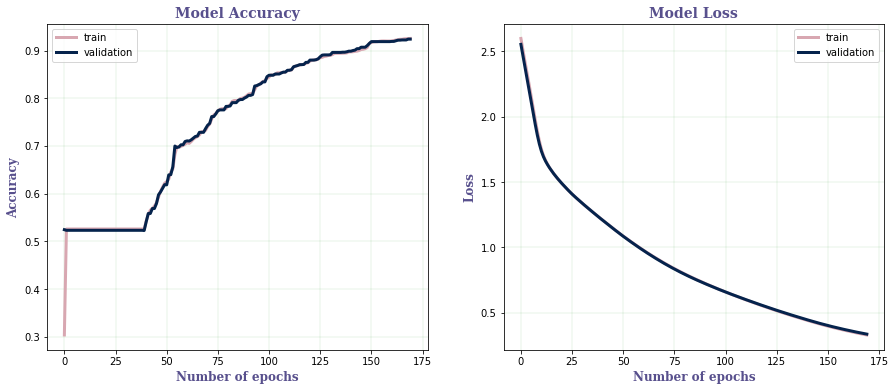

In [68]:
model6_history, model6 = create_model(train, label_train, test, label_test, model6_params)

Model 6 had the best performance on the random sample, with about 74% accuracy.

## Confusion Matrix

We'll create a confusion matrix to get a fuller sense of how the model performed on the random sample.  

In [53]:
label_preds = model6.predict_classes(r_descriptor_onehot)
label_preds_onehot = to_categorical(label_preds)

In [54]:
cf_matrix = confusion_matrix(r_agency_cat, label_preds)

Text(0.5, 96.0, 'Predicted Agency')

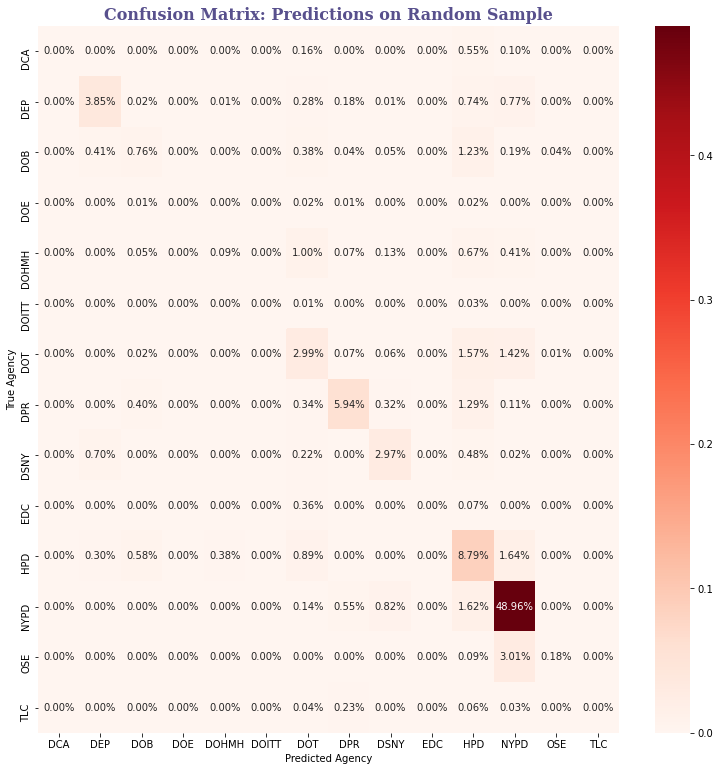

In [55]:
plt.figure(figsize=(13, 13))
plt.title('Confusion Matrix: Predictions on Random Sample', 
          fontdict={'fontsize': 16, 'family': 'serif', 'color': '#58508d', 'weight': 'bold'})

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, xticklabels=le.classes_, yticklabels=le.classes_,
            fmt='.2%', cmap='Reds')
plt.ylabel('True Agency')
plt.xlabel('Predicted Agency')

# Interpreting the Results
With 91% accuracy on the resampled test data, and 73.8% accuracy on the random subset, the sixth model had the best overall performance. 

- The model correctly predicted that roughly half (49%) of calls received a response from the NYPD. 
- About 9% of predictions were correct HPD classifications.
- About 6% were correct DPR classifications. 
- About 3% were correct DOT classifications, and another 3% were correct DSNY classifications.
- Despite being trained on resampled data, the model still mis-classified the responding agency of some calls as the NYPD, HPD, or DOT. About 1.6% of calls, for example, were DOT but classified as HPD.

Similar models can be trained and broadened in scope to optimize the assignment of future complaints to a responding agency. 

# References 
[Hyperparameter Optimization with Keras]('https://towardsdatascience.com/hyperparameter-optimization-with-keras-b82e6364ca53')